# Smoke & Fire Detection in Forest Environment
Wildfires or forest fires are **unpredictable catastrophic and destructive events** that affect rural areas. The impact of these events affects both **vegetation and wildlife**. In this project, we propose an application to **detect smoke and/or fire in forest environments**. In particular, we can imagine a setup in which webcams, drones, or other recording devices take pictures of a wild environment every t seconds or minutes. The proposed system is then able to **classify the current situation** as *normal*, *smoke*, or *fire*. The system is not real-time since wildfires are events that evolve more slowly than others (e.g., traffic accidents).

## Introduction
According to the European Forest Fire Report [1] the 2021 fire season in Europe, Middle East and North Africa was the worst ever recorded in terms of area affected by fires. A total of 500,566 hectares (ha) burned, and Italy is reported to be the most affected country. Early fire detection in rural and remote areas is a challenge, even with the help of sensors, but it would allow authorities to be alerted in time and limit damage and burned areas.

Some related works include [2] which proposes a method to detect active fires and burning biomass from satellite images (Landsat-8 dataset). In [3] they propose a UAV platform for the pur- pose of forest fire detection. They developed a small-scale convolutional neural network (CNN) implemented with the help of YOLOv3. Fire is detected in an object-detection fashion. In [4] they used video frames with fire taken from CCTV in combination with a CNN. The dataset was self built by researchers.

## Proposed Solutions
The proposed system consists of **two main solutions**. In the first solution we design, train, and evaluate a **custom CNN**. Regarding the second solution, we will fine-tune a pretrained **vision transformer**, the Google ViT [9], hosted on the Hugging Face Hub [8]. Results are logged and proposed through WanDB [7]. The performance of the two solutions will be compared and different aspects will be discussed.

The framework used for this experiment is PyTorch with the PyTorch Lightning Module. The final web application to showcase the model is written in Python using the Streamlit library and hosted on the Hugging Face Hub.

## Data Sources
The dataset used in this project is **self-built** by merging two **datasets from Kaggle**. In particular, we used samples from ”train_fire” and ”train_smoke” from [5], and all the samples (mixed together from further splitting) from [6].

The final dataset consists of **2525 samples for each of the three classification classes** (fire, smoke, normal). This dataset will be then split into train, validation, and test sets. The images in the dataset depict **fires of different magnitude**, **from different perspectives** (aerial, far, near) thus **simulating images from different devices**, such as webcams and drones.

## 0. Importing Tools

We start by importing the necessary tools for both the solution proposed.

In [1]:
# GENERAL
import math
import os
import splitfolders
import numpy as np
# PYTORCH
import torch
from torch import optim, nn, utils, Tensor
from torch.utils.data import random_split,  DataLoader
from torch.optim.lr_scheduler import LambdaLR
import torch.nn as nn
import torch.nn.functional as F
# TORCHMETRICS & TORCHVISION & TORCHSUMMARY
import torchmetrics
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, RandAugment
from torchsummary import summary
# LIGHTNING MODULE
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor, RichProgressBar
# HUGGINGFACE UTILITIES
from datasets import load_dataset
import evaluate
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
# PLOTTING & LOGGING
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import wandb

## 1. Prepare and Organize Data on Disk

The first operation consists in **preparing the train, validation, and test sets** starting from a **collection of labeled images**. The following code uses the `splitfolders` module to split the data located in the `./RawFireData/` directory. The data is split in the ratio of **80% for training, 10% for testing, and 10% for validation**. The split is done using a random seed of 42 to ensure reproducibility. The data is not moved from its original location but copied into a new direcotry, named `./FireData/`.

In [ ]:
# Split data into train, test, val
if not os.path.isdir("./FireData"):
    splitfolders.ratio("./RawFireData/", output="./FireData/", seed=42, ratio=(.8, .1, .1), move=False)
else:
    print("Files are present on the disk!")

## 2. First Approach: A Custom CNN

In this section, we propose a **solution based on a custom Convolutional Neural Network (CNN) architecture** for the classification of fire and smoke in wild environments. The solution is developed using the **PyTorch Lightning module**, which allows for **efficient and organized implementation** of the network. The solution includes a custom **data module** to handle the input data and a custom **network module** to define the CNN architecture. The results are logged using the WanDB, which provides a platform to track and analyze the performance of machine learning experiments.

**Convolutional Neural Networks** (CNNs) are a type of deep learning model widely used for **image-related tasks**, such as image classification, object detection, and segmentation. They are designed to **process and analyze grid-like structures**, such as images, by using a series of convolutional and pooling operations to **extract and process features** from the input.

The key features of a CNN include:
- **Convolutional layers**: these layers apply a set of filters to the input image, producing feature maps that capture specific patterns and features in the image.
- **Pooling layers**: these layers down-sample the feature maps, reducing the spatial size and computational cost of the network while retaining important information.
- **Non-linear activation functions**: these functions introduce non-linearities into the network, allowing it to learn complex relationships between the input and output.
- **Fully connected layers**: these layers take the processed features from the convolutional and pooling layers and use them to make a prediction about the class of the input image.

Overall, CNNs are **highly effective for image-related tasks** and have achieved state-of-the-art results on many benchmark datasets.

### 2.1 General training parameters

Before starting the experiment, we define some general parameters. The choice of learning rate and batch size is not arbitrary but **guided by results of several previous experiments**.

In [2]:
# Define general parameters
batch_size = 32
img_height = 224
img_width = 224
learning_rate = 0.001
epochs = 20
num_classes = 3

### 2.2 Define the Data Module

Before designing the network, we define our **data module**, `FireDataModule`, that inherits from the `LightningDataModule` class belonging to the PyTorch Lightning library. The class has several methods:
- The `__init__` method sets up the class with values for the `path`, `batch_size`, `img_height`, and `img_width` attributes. It also sets up the `prepare_data_per_node` and `_log_hyperparams` attributes.

- The `prepare_data` method is used to download and process data, but it is not implemented in this code.

- The `setup` method performs the **data processing and preparation**. It creates a set of transformation using the `Compose` method from the `torchvision` library. In addition to **resizing** and **normalization**, we also apply a set of **random augmentation operations**, with `RandAugment`[10]. Images are then **converted into Tensors**. Based on the stage argument, the `setup` method prepares the train, validation, and test datasets using the `ImageFolder` method from the `torchvision.datasets` library.

- The `train_dataloader`, `val_dataloader`, `test_dataloader`, and `predict_dataloader` methods create **PyTorch data loaders** for the train, validation, test, and predict sets, respectively. These data loaders are used to **load the data in batches**.

In [3]:
# Define the PyTorch Lightning Data Module
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path="./FireData", batch_size=32, img_height=250, img_width=250):
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.PATH = path
        self.prepare_data_per_node = False
        self._log_hyperparams = False
        
    def prepare_data(self):
        #download, tokenize, ecc
        pass

    def setup(self, stage=None):
        # Set transformations
        train_transform = Compose([Resize((self.img_height, self.img_width)),
                                RandAugment(num_ops=2, magnitude=9),
                                ToTensor(),
                                Normalize(0.5, 0.5)
                               ])

        val_transform = Compose([Resize((self.img_height, self.img_width)),
                                ToTensor(),
                                Normalize(0.5, 0.5)
                                ])
        # Assign train/val datasets for use in dataloaders
        # the stage is used in the Pytorch Lightning trainer method, which you can call as fit (training, evaluation) or test
        # also you can use it for predict, not implemented here
        if stage == "fit" or stage is None:
            data_dir = self.PATH + '/train' 
            self.train =  datasets.ImageFolder(data_dir, transform=train_transform)
            data_dir = self.PATH + '/val' 
            self.validate = datasets.ImageFolder(data_dir, transform=val_transform)

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            data_dir = self.PATH + '/test' 
            self.test = datasets.ImageFolder(data_dir, transform=val_transform)
            
    # Define dataloaders
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=10)

    def val_dataloader(self):
        return DataLoader(self.validate, batch_size=self.batch_size, shuffle=False, num_workers=10)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, num_workers=10)

    def predict_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, num_workers=10)

### 2.3 Define the Network Module

After the data module, we define a **custom CNN** implemented as a PyTorch Lightning module. The module extends the `LightningModule` class from the PyTorch Lightning library, which is a high-level library for PyTorch. 

- In the class definition, the `__init__` method sets up several important components of the model: 1) **Initializes the hyperparameters** learning_rate and num_classes that are passed as arguments to the constructor; 2) Defines a set of **metrics** to evaluate the performance of the model during training, validation, and testing. The metrics include accuracy, precision, recall, and F1-score, and are defined using the torchmetrics library. The metrics are **kept separate** for training, validation, and testing with different prefixes for each set; 3) Defines the **architecture** of the CNN, in combination with `forward`.

- The `loss_fn` method defines the **loss function** to use for training. In this case, it's using the **cross-entropy loss**.

- The `training_step` method implements the **logic for a single training step**. It takes a batch of data, makes a forward pass through the network to get the logits, calculates the loss using the `loss_fn` method, and logs the loss and the training metrics for the batch.

- The `validation_step` method implements the **logic for a single validation step**. It takes a batch of validation data, makes a forward pass through the network to get the logits, calculates the loss using the `loss_fn` method, and logs the loss and the validation metrics for the batch.

- The `test_step` method is similar to the `validation_step` method but logs the results with the test prefix.

- The `prediction_step` method returns the **probabilities of belonging to each of the three classes** given a batch of data.

- The `configure_optimizers` method defines the **optimizer and the LR scheduler** to use for training, which in this case are the **AdamW** optimizer with an **exponential learning rate scheduler**.

**Network Architecture:**
- The first convolutional layer has **64 filters** with a **kernel size of 9** and a **stride of 2**. It takes in 3 channel input images and applies the filters to generate 64 feature maps. The first batch normalization layer **normalizes the output** from the first convolutional layer. The first pooling layer performs **max pooling** with a kernel size of 3. The architecture includes **two more pairs of convolution, normalization and pooling layers**. The final two convolutional layers have **128 filters** each, with a **kernel size of 3**, and **stride and padding of 1**. The final flattening layer **flattens the output** of the fourth convolutional layer into a 1D vector. The first fully connected layer has **1024 output units** and the final layer outputs **3 class scores**, which are passed through a **softmax function** to generate class probabilities. The activation function used in the network is **Scaled Exponential Linear Unit (SELU)** and **dropout** is applied after some layers with a probability of 0.1 or 0.5.
- Dilatations allow to increase the receptive field without increasing the number of parameters.
- The SELU activation function perform a self normalization, so leads to faster convergence [12]. SELU also avoid vanishing gradients (like ReLU and the dead ReLU problem).

**Loss Function:**
- The loss function is the Cross Entropy Loss.

**Optimizer:**
- AdamW with betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01

**Learning Rate Scheduler:**
- Exponential learning rate scheduler with gamma=0.9

**Metrics:**
- The metrics include Accuracy, Precision, Recall, and F1 Score. They are all multi-class metrics, with weighted average over the classes.

In [4]:
# Define the PyTorch Lightning Network Module, that is the custom CNN
class fireDec(pl.LightningModule):
    def __init__(self, learning_rate, num_classes):
        self.lr=learning_rate
        self.num_classes = num_classes
        super().__init__()
        # Define metrics
        metrics = torchmetrics.MetricCollection({
            'acc' : torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes, average="weighted"),
            'prec' : torchmetrics.Precision(task="multiclass", num_classes=self.num_classes, average="weighted"),
            'rec' : torchmetrics.Recall(task="multiclass", num_classes=self.num_classes, average="weighted"),
            'F1' : torchmetrics.F1Score(task="multiclass", num_classes=self.num_classes, average="weighted")
        })

        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

        # Define the custom network
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=2, padding=1, dilation=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2, dilation=3)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=3)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=2, dilation=2)
        self.bn4 = nn.BatchNorm2d(128)

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(in_features=12800, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=3)

    def forward(self, x):
        x = self.pool1(F.selu(self.bn1(self.conv1(x))))
        x = F.dropout(x, 0.1)

        x = self.pool2(F.selu(self.bn2(self.conv2(x))))
        x = F.dropout(x, 0.1)

        x = F.selu(self.bn3(self.conv3(x)))
        x = F.selu(self.bn4(self.conv4(x)))
        x = F.dropout(x, 0.1)

        x = self.flat(x)

        x = F.selu(self.fc1(x))
        x = F.dropout(x, 0.5)

        x = F.softmax(self.fc2(x), dim=1)
        return x

    # Define the loss function
    def loss_fn(self, logits, y):
        loss = nn.CrossEntropyLoss()
        return loss(logits, y)

    # Define the training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits,y)
        #self.metrics.update(logits, y)

        self.log('train_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log_dict(self.train_metrics(logits, y), on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # Define the validation step
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        #self.metrics.update(logits, y)
        self.log('val_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log_dict(self.val_metrics(logits, y), on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # Define the test step
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        #self.metrics.update(logits, y)
        self.log('test_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log_dict(self.test_metrics(logits, y), on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    # Define the predict step
    def predict_step(self, pred_batch, batch_idx, dataloader_idx=0):
        x, y = pred_batch
        logits = self.forward(x)
        return logits.softmax(dim=-1)

    # Define the Optimizer and the LR scheduler
    def configure_optimizers(self):
        opt1 = optim.Adam(self.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
        optimizers = [opt1]
        lr_schedulers = {"scheduler": optim.lr_scheduler.ExponentialLR(optimizer=opt1, gamma=0.9), "interval": "epoch"}
        return optimizers, lr_schedulers

    # Define the scheduler step
    def lr_scheduler_step(self, scheduler, optimizer_idx, metric):
        scheduler.step()

The `summary` module gives us a compact but detailed representation of the **network structure and paramters**. In particular, this CNN has a total of **13,923,203 trainable paramters**.

In [5]:
# Display the summary of the custom CNN
summary(fireDec(learning_rate=learning_rate, num_classes=3), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]          15,616
       BatchNorm2d-2         [-1, 64, 122, 122]             128
         MaxPool2d-3           [-1, 64, 40, 40]               0
            Conv2d-4          [-1, 128, 32, 32]         204,928
       BatchNorm2d-5          [-1, 128, 32, 32]             256
         MaxPool2d-6          [-1, 128, 10, 10]               0
            Conv2d-7          [-1, 256, 10, 10]         295,168
       BatchNorm2d-8          [-1, 256, 10, 10]             512
            Conv2d-9          [-1, 128, 10, 10]         295,040
      BatchNorm2d-10          [-1, 128, 10, 10]             256
          Flatten-11                [-1, 12800]               0
           Linear-12                 [-1, 1024]      13,108,224
           Linear-13                    [-1, 3]           3,075
Total params: 13,923,203
Trainable para

In order to **log the prediction results** of the model we define custom callback. This class logs the prediction results, in the form of sample images, to the Weights & Biases (WanDB) dashboard. The class is defined as a subclass of PyTorch Lightning's Callback class and overrides its `on_validation_epoch_end` and `on_test_epoch_end methods`.

In the constructor, it takes three arguments:

- `val_samples`: A tuple of validation images and their corresponding labels.
- `test_samples`: A tuple of test images and their corresponding labels.
- `num_samples`: The number of sample images to be logged (defaults to 32).

The `on_validation_epoch_end` method is called at the end of each validation epoch, and it **logs the model's predictions on the validation set** to the W&B dashboard. The validation images and labels are moved to the same device as the model and passed through the model to get its predictions. The predictions are then converted to class indices using the `torch.argmax` function. The sample images along with their corresponding predictions and actual labels are then logged as a W&B Image to the dashboard.

The `on_test_epoch_end` method works similarly, but **logs the model's predictions on the test set** instead of the validation set.

In [6]:
# Define a callback to log samples images in the WanDB board
class ImagePredictionLogger(pl.callbacks.Callback):
    def __init__(self, val_samples, test_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
        self.test_imgs, self.test_labels = test_samples
    
    def on_validation_epoch_end(self, trainer, pl_module):
        # Bring the tensors to CPU
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
        # Get model prediction
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        # Log the images as wandb Image
        trainer.logger.experiment.log({
            "VALIDATION":[wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })

    def on_test_epoch_end(self, trainer, pl_module):
        # Bring the tensors to CPU
        test_imgs = self.test_imgs.to(device=pl_module.device)
        test_labels = self.test_labels.to(device=pl_module.device)
        # Get model prediction
        logits = pl_module(test_imgs)
        preds = torch.argmax(logits, -1)
        # Log the images as wandb Image
        trainer.logger.experiment.log({
            "TEST":[wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                            for x, pred, y in zip(test_imgs[:self.num_samples], 
                                                    preds[:self.num_samples], 
                                                    test_labels[:self.num_samples])]
            })

### 2.4 Train & Evaluate the Network with WanDB Logger and LR Finder

Before training the network there are some necessary operations to carry out. In particular, we need to **load and setup the dataset**. We also **plot some sample images** from the training set, to see the effects of the random augmentation.

The `prepare_data` method is called to load the data and perform any necessary processing, and the `setup` method is called to set up the data for use with a PyTorch Lightning model.

In [7]:
# Define the newtork, prepare the data and setup
dm = FireDataModule(path="./FireData", batch_size=32, img_height=250, img_width=250)
dm.prepare_data()
dm.setup()

In [8]:
# Load the samples (that will be used to visluaze the images and for the WanDB board callback)
train_samples = next(iter(dm.train_dataloader()))
val_samples = next(iter(dm.val_dataloader()))
test_samples = next(iter(dm.test_dataloader()))

class_names = dm.train.classes
class_names

['Fire', 'Normal', 'Smoke']

In [ ]:
# Define a function to plot some samples and respective labels
def plotSamples(samples, class_names, figsize=(30,30)):
    imgs, labels = samples[0], samples[1]
    plt.figure(figsize=(30, 30))
    for i in range(8):
        ax = plt.subplot(10, 4, i+1)
        plt.imshow(imgs[i].permute(1,2,0))
        plt.title('Class:'+class_names[labels[i]])
        plt.axis('off')
        plt.grid(True)

plotSamples(train_samples, class_names)

<figure>
<img src="./IMG/CNN_samples.png" style="width:2200px;display: block;margin-left: auto;margin-right: auto;">
<figcaption align = "center">Some of the training samples. As can be seen, augmentation operations were performed.</figcaption>
</figure>

At this point, we can start the **training and evaluation phase**. First, we start the WanDB logging session, then we instanciate the custom CNN network. The model is then set up with a PyTorch Lightning Trainer, using a GPU accelerator and setting all the required parameters. We make also use of the `tuner` fuctionality provided by `Trainer` in order to find a suggested learnin rate.

Please note that:
- The trainer has a `LearningRateMonitor` callback, an `ImagePredictionLogger` callback, and a `RichProgressBar` callback. 
- The **learning rate finder** functionality is run to get a **suggested learning rate** and the model's hyperparameters are updated accordingly. A plot represents the suggested learning rate and reports the tested values.
- The model is then **trained using the data module** and finally, the trainer **tests the model using the test data**. Training and evaluation results are reported.

In [ ]:
# Setup the WanDB logger
wandb_logger = WandbLogger(project='fireDet_custom_CNN', job_type='train')

# Instanciate the model and define the PyTorch Lightning Trainer, set LR monitor callback, setup the trainer
model = fireDec(learning_rate=learning_rate,  num_classes=3)
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(max_epochs=epochs, accelerator="mps", devices=1, logger=wandb_logger, enable_model_summary=False, auto_lr_find=True, callbacks=[lr_monitor, 
                                                                                                                                            ImagePredictionLogger(val_samples, test_samples),
                                                                                                                                            RichProgressBar()])

# Run learning rate finder, get a suggestion and update the model hparam
lr_finder = trainer.tuner.lr_find(model, datamodule=dm, num_training=100)
fig = lr_finder.plot(suggest=True)
fig.show()
new_lr = lr_finder.suggestion()
print("SUGGESTED LR: " + str(new_lr))
model = fireDec(learning_rate=new_lr, num_classes=3)

# Train and evaluate the model
trainer.fit(model=model, datamodule=dm)
trainer.test(dataloaders=dm.test_dataloader())

# End the logging session
wandb.finish()

The following image shows the plot with the suggested learning rate and reports all the values about model performance.
<figure>
<img src="./IMG/CNN_LR_Summary.png" style="width:1000px;display: block;margin-left: auto;margin-right: auto;">
<figcaption align = "center">The output of the learning rate finder (left); Performance of the CNN model (right)</figcaption>
</figure>

The following image shows the report generated using the WanDB logger.
<figure>
<img src="./IMG/CNN_stats.png" style="width:1000px;display: block;margin-left: auto;margin-right: auto;">
<figcaption align = "center">The report obtained from WanDB logger.</figcaption>
</figure>

### 2.5 Confusion Matrix of Results

After the traing and evaluation phases, we can use of the `predict` method to **get predictions** on the test set and **build a confusion matrix**.

In [ ]:
# Getting prediction from the test set
test_loader = dm.test_dataloader()
outputs = trainer.predict(model, test_loader)

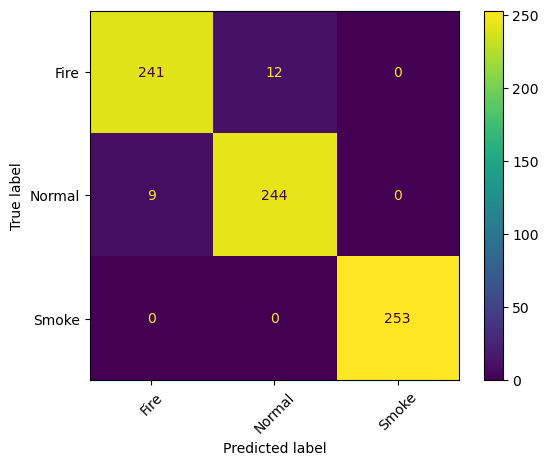

In [12]:
# Compute and visualize the confusion matrix with results from the trained model
preds, true_labels = [], []
for res in outputs:
    preds.extend(res.argmax(1).tolist())

for data in test_loader:
    true_labels.extend(data[1].tolist())

labels = ['Fire', 'Normal', 'Smoke']
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

### 2.6 Discussion

In this section we defined and trained a CNN for image classification. Overall model performance is not bad with precision hitting 0.99 and recall 0.97. However, the network **still makes mistakes**: in 12 cases a **dangerous situation (fire) was classified as normal**. This, in an application scenario, could lead to **failure to alert the emergency services** in time. Conversely, in 9 cases a **normal situation was reported as dangerous (fire)**. Although this error has a lower cost (a false alarm is better than an unreported fire) it would be good to limit both. 

Considerations for **possible improvements** are given at the end of the report, in the section "Final Remarks & Future Work"

## 3. Second Approach: ViT Vision Transformer

In this section, we propose a **transformer-based solution** for the classification of fire and smoke in wild environments. In particular, we **fine-tune the pre-trained Google Vision Transformer** [9]. This fine-tuning process **adjusts the weights of the model to the specific downstream task** of fire and smoke classification.

Vision Transformers are a type of deep learning model that have recently achieved **state-of-the-art results** on a variety of computer vision tasks, including image classification, object detection, and segmentation. They are based on the **transformer architecture**, which was originally developed for **natural language processing** tasks.

The key features of vision transformers include:
- **Self-attention mechanism**: this mechanism allows the model to attend to different regions of the input image in parallel, producing a global representation of the image. Self-attention allows the model to **focus on the most relevant regions** of the input and capture complex relations between different input parts.
- **Multi-head attention**: this mechanism allows the model to attend to different aspects of the input image, improving its ability to capture complex relationships.
- **Positional encoding**: this encoding allows the model to incorporate the spatial structure of the input image, even though the model does not explicitly use convolutional or pooling operations.

In order to make experimental **data open and accessible**, we will upload the custom-made dataset to the **Hugging Face Hub**. The final fine-tuned model will also be uploaded and made availbale on the Hugging Face Hub. 

Since (vision) transformers are complex architectures, we followed some of the advice presented in [11].


<figure>
<img src="./IMG/ViT_Architecture.png" style="width:700px;display: block;margin-left: auto;margin-right: auto;">
<figcaption align = "center">The structure of ViT, image from [11] </figcaption>
</figure>

### 3.1 General Training Parameters

As in the first solution, we set some **general parameters** and specify the correct to device to train with the M1 chip performance.

In [2]:
# Set the device to Apple Silicon M1 chip
device = torch.device('mps')

In [3]:
# Define general parameters
batch_size = 32
img_height = 224
img_width = 224
learning_rate = 2e-4
epochs = 10
num_classes = 3

### 3.2 Get the Data

Since the final model will be uploaded on the HF Model Hub, it's also good to **upload on the Hub the dataset used**. This instructions load the data from the disk and push upload them to the HF Data Hub. This operation is to execute only once.

`dataset = load_dataset("imagefolder", data_dir="./FireData", drop_labels=False)`

`dataset.push_to_hub("EdBianchi/SmokeFire")`

Since the dataset is now online, we can simply load it with `load_dataset()`. In this way, **the dataset is in the format required in order to use the pre-trained model** from Hugging Face.

In [ ]:
# Download the dataset from the Hub
ds = load_dataset("EdBianchi/SmokeFire")
ds

Label: 0


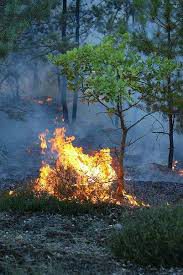

In [5]:
# Pick a sample from the dataset
ex = ds['train'][667]
print("Label: " + str(ex['label']))
ex['image']

### 3.3 Data Preprocessing

Since we are using a specific pre-trained model, we need also the **correct pre-trained feature extractor**. The feature extractor is used to ensure that the paramters that we will use for the fine-tuning operation are **the same used during the pre-training phase**.

In [6]:
# Define the model to use and the feature extractor
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

In [7]:
# Print shape of the tensor of a sample image
sample_tensor = feature_extractor(ex['image'], return_tensors='pt')
sample_tensor['pixel_values'].shape

torch.Size([1, 3, 224, 224])

As for the custom CNN, we define some **image pre-processing** steps for both training and validation data. In particular, the `train_transforms` and `val_transforms` functions take in a batch of images and apply **resizing**, **tensor conversion**, and **normalization** to each image in the batch. We apply random augmentations to the train set, using RandAugment[10]. The transformed images are then stored as `pixel_values` in the batch.

In [8]:
# Define a normalizer
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# Define the transformation to apply to the images from train and val samples
_train_transforms = Compose(
        [
            Resize((feature_extractor.size['width'],feature_extractor.size['height'])),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            normalize
        ]
    )

_val_transforms = Compose(
        [
            Resize((feature_extractor.size['width'],feature_extractor.size['height'])),
            ToTensor(),
            normalize
        ]
    )

# Define the actual function that applies the transformations to the samples
def train_transforms(batch):
    batch['pixel_values'] = [_train_transforms(x.convert("RGB")) for x in batch['image']]
    return batch

def val_transforms(batch):
    batch['pixel_values'] = [_val_transforms(x.convert("RGB")) for x in batch['image']]
    return batch

In [9]:
# Apply the transformations to the samples. Note that the set_transform() functions modifies in-place.
ds['train'].set_transform(train_transforms)
ds['validation'].set_transform(val_transforms)
ds['test'].set_transform(val_transforms)

### 3.4 Define Data Collator and Evaluation Metrics

Next, we define a **custom collate function** to use in the PyTorch DataLoader. This function **takes in a batch of data**, which is a list of dictionaries each containing `pixel_values` and `labels` as keys. It **returns a dictionary containing two tensors** `pixel_values` and `labels`, which are created by **stacking** the `pixel_values` from each dictionary in the batch and creating a tensor from the `labels` from each dictionary in the batch, respectively.

In [10]:
# Define the data collator
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

As for the CNN, we want to measure **precision** and **recall** as performance metrics. The `compute_metrics` function loads the two metrics from the `evaluate` library. It then converts the predictions from a 2D tensor to a 1D numpy array, and extracts the corresponding label ids. The precision and recall values are computed using the `compute` method from each metric. Precision and recall values are then **returned as a dictionary** with the keys "precision" and "recall".

In [11]:
# Define the function that will compute precision and recall (metrics)
def compute_metrics(eval_pred):
    metric1 = evaluate.load("precision")
    metric2 = evaluate.load("recall")
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids

    precision = metric1.compute(predictions=preds, references=labels, average="weighted")["precision"]
    recall = metric2.compute(predictions=preds, references=labels, average="weighted")["recall"]

    return {"precision": precision, "recall": recall}

### 3.5 Download, Fine-Tune, and Evaluate the Model

We now **instanciate a pre-trained Vision Transformer** (ViT) model for image classification from the **Hugging Face Transformers library**. The `model_name` variable specifies the name of the pre-trained ViT model (and checkpoint) to be used. The `num_labels` argument sets the number of classes in the target variable, which is set to `num_classes`. The `id2label` and `label2id` dictionaries map the class label indices to their corresponding class names and vice versa. Finally, the model is moved to the MPS (Metal Performance Shaders) device.

In [ ]:
# Load a pretrained model --> vit-base-patch16-224-in21k and define classes and labels
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = num_classes,
    id2label = {0:'Fire', 1:'Normal', 2:'Smoke'},
    label2id = {'Fire':0, 'Normal':1, 'Smoke':2})

model.to(device)

Another important step is to **define the training arguments**. This is done with `TrainingArguments`. The model is set to use the device with MPS with a batch size of `batch_size` for both training and evaluation. The output of the training will be saved in the directory `./vit-fire-detection` and the training will run for `epochs` epochs. The logging will be done every 50 steps and the model will be saved every epoch, with a total limit of 1 saved model. The training will start with a **warm-up period** of 100 steps.

We adopt the **AdamW optimizer** with `betas` as (0.9,0.999), `epsilon` as 1e-8, and `weight_decay` as 0.01. A **linear LR scheduler** is employed by default.

In [13]:
# default uses adamW optimizer
training_args = TrainingArguments(
  use_mps_device=True,
  output_dir="./vit-fire-detection",
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size=batch_size,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  logging_steps=50,
  num_train_epochs=epochs,

  learning_rate=learning_rate,
  weight_decay=0.01,
  adam_beta1=0.9,
  adam_beta2=0.999,
  adam_epsilon=1e-8,
  warmup_steps=100,

  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub="end", #set to "end" and call save_model()
  report_to=None,
  load_best_model_at_end=True
)

A `Trainer` is instantiated using the defined `model`, `training_args`, `collate_fn` as the data collator, `compute_metrics` for evaluation, and the `train_dataset` and `eval_dataset` as the train and validation datasets, respectively. The `tokenizer` is also passed as the feature extractor.

In [ ]:
# Define the Trainer and set the parameters
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=feature_extractor
)

At this point, we can **train and evaluate the model**, logging the procedure using WanDB. After the training step, the model is evaluated against the test set.

In [ ]:
# Traine the model logging metrics and reporting to WanDB.
train_results = trainer.train()
trainer.log_metrics("train", train_results.metrics)
trainer.log_metrics("eval", train_results.metrics)
wandb.finish()

The following image reports all the values about model performance and training history.
<figure>
<img src="./IMG/ViT_summary.png" style="width:1000px;display: block;margin-left: auto;margin-right: auto;">
<figcaption align = "center">Training history of ViT and model performance</figcaption>
</figure>

The following image shows the report generated using the WanDB logger.
<figure>
<img src="./IMG/ViT_stats.png" style="width:1000px;display: block;margin-left: auto;margin-right: auto;">
<figcaption align = "center">The report obtained from WanDB logger.</figcaption>
</figure>

In [ ]:
# Evaluate the trained model
outputs = trainer.predict(ds['test'])
print(outputs.metrics)

As for the custom CNN, we use the predictions and the label to build and plot a **consufion matrix**.

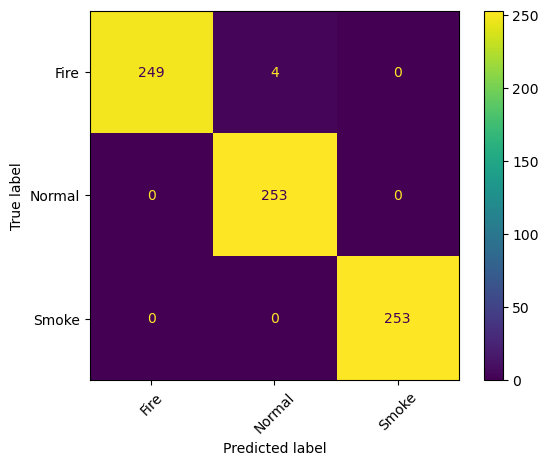

In [17]:
# Compute and visualize the confusion matrix with results from the trained model
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = ['Fire', 'Normal', 'Smoke']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

### 3.6 Upload the Fine-Tuned Model to the Hub

With a simple instruction is it possible to **upload the fine-tuned model to the Hugging Face Hub**. The model is available at this link: <https://huggingface.co/EdBianchi/vit-fire-detection>

In [ ]:
# Upload the model to the Hub to make it accesible and public
trainer.save_model()

### 3.7 Use the Model with HF Pipeline

Once a model is uploaded to the hub, it can be **used extremely easily**. This example shows how to use the model we have trained, classifying an image.

In [ ]:
from transformers import pipeline
from PIL import Image

image = Image.open("./APP/fog.jpeg")
pipeline = pipeline(task="image-classification", model="EdBianchi/vit-fire-detection")
predictions = pipeline(image)

In [20]:
predictions

[{'score': 0.9969803690910339, 'label': 'Normal'},
 {'score': 0.0027111759409308434, 'label': 'Fire'},
 {'score': 0.00030844550929032266, 'label': 'Smoke'}]

The following image, `fog.jpeg`, has been **correctly classified** by the model as "normal", depicts a fog situation and not a smoke situation. This means that the model has learned to **distinguish basic features** not only of a fire situation, but also of a smoke situation, which is more complicated (e.g., fog could be misclassified as smoke).
<figure>
<img src="./APP/fog.jpeg" style="width:400px;display: block;margin-left: auto;margin-right: auto;">
<figcaption align = "center">A sample correctly image classified by the model</figcaption>
</figure>

## 4. Discussion
We trained the ViT for only 10 epochs, due to the long training time required. The overall performance of the model is good, but the network **still makes a few mistakes**: in 4 cases a **fire situation was classified as normal**. This, in an application scenario, could lead to **failure to alert the emergency services** in time. Choosing the right learning rate was the real challenge here: we had to test several values before finding one that maximizes the performance of the model.

Considerations for **possible improvements** are given at the end of the report, in the section "Final Remarks & Future Work".

## 5. Streamlit WebApp to Showcase the Model

To showcase the final model, we developed a simple web application, available at <https://huggingface.co/spaces/EdBianchi/Forest-Fire-Detection> The demo allows the user to upload an image and predict if there is a smoke, fire or normal situation. We report here a screenshot of the GUI.

<figure>
<img src="./IMG/WebApp.png" style="width:700px;display: block;margin-left: auto;margin-right: auto;">
<figcaption align = "center">The web application used to test and showcase the model</figcaption>
</figure>


## 6. Final Remarks & Future Work

In this project we proposed **two solutions** to the same problem using **different technologies**. I tried to cover many of the topics covered in the course and apply what I learned in order to solve a **real-world problem**. Both solutions work well, and an interactive demo allows to see the **ViT model at work**.

As future work, we would like to train both models for **more epochs**, test **different activation** functions, and try a **different scheduler** for ViT.

Another point to investigate is the data **augmentation phase**: the main question is whether in this application domain data augmentation operations "distort" the semantics of the images.

I conclude keeping in my mind that *"All models are wrong, but some are useful"*, i hope these can be useful ones.

Edoardo Bianchi - 20740

## References
[1] European forest fire report: Three of the worst fire seasons on record took place in the last six years[J]. 2022.

[2] Pennazza G, Seydi S T, Saeidi V, et al. Fire-net: A deep learning framework for active forest fire detection[J]. Journal of Sensors, 2022, 2022: 8044390. http://dx.doi.org/10.1155/2022/ 8044390.

[3] Jiao Z, Zhang Y, Xin J, et al. A deep learning based forest fire detection approach using uav and yolov3.

[4] Vadakkadathu Rajan G, Paul S. Forest fire detection using machine learning[J]. 2022.

[5] KUTLU K. Forest fire dataset on kaggle[EB/OL]. https://www.kaggle.com/datasets/kutaykutlu/forest-fire?select=train_fire.

[6] PRASAD M S. Forest fire images dataset on kaggle[EB/OL]. https://www.kaggle.com/datasets/mohnishsaiprasad/forest-fire-images. 

[7] Biewald L. Experiment tracking with weights and biases. Software available from wandb.com.

[8] Hugging face[EB/OL]. https://huggingface.co.

[9] B. Wu et al., Visual Transformers: Token-based Image Representation and Processing for Computer Vision. arXiv, 2020. doi: 10.48550/ARXIV.2006.03677.

[10] E. D. Cubuk, B. Zoph, J. Shlens, and Q. V. Le, RandAugment: Practical automated data augmentation with a reduced search space. arXiv, 2019. doi: 10.48550/ARXIV.1909.13719.

[11] A. Steiner, A. Kolesnikov, X. Zhai, R. Wightman, J. Uszkoreit, and L. Beyer, “How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers,” 2021, doi: 10.48550/ARXIV.2106.10270.

[12] A. Nguyen, K. Pham, D. Ngo, T. Ngo, and L. Pham, An Analysis of State-of-the-art Activation Functions For Supervised Deep Neural Network. arXiv, 2021. doi: 10.48550/ARXIV.2104.02523.